# Notebook para la competición de Kaggle [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)
Identify metastatic tissue in histopathologic scans of lymph node sections

[Notebook de ayuda](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch/notebook)

In [1]:
from javIA_oop import *

AI framework by Javi based in PyTorch: 0.4.1


In [2]:
class CancerDataset(ImageDataset):

	def __init__(self, img_dir, csv_name, transforms=False, limit=False):
		dataset_dir = pathlib.Path("C:/Users/Javi/Desktop/Datasets/PCam")
		csv_df      = pd.read_csv(dataset_dir / csv_name)

		self.image_dir  = dataset_dir / img_dir
		self.images     = (csv_df["id"]+".tif").values
		self.labels     = (csv_df["label"]).values
		self.labels_map = {0: "sano", 1: "cancer"}
		self.transforms = transforms
		self.limit      = limit

dataset = CancerDataset("train", "train_labels.csv", limit=10000)
test_ds = CancerDataset("test", "sample_submission.csv")
print("There are", len(dataset), "images in the labeled dataset.")
print("There are", len(test_ds), "images in the test dataset.")

There are 10000 images in the labeled dataset.
There are 57458 images in the test dataset.


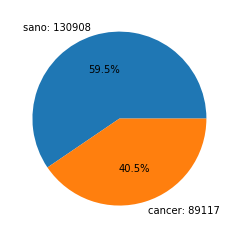

In [3]:
dataset.plot_balance()

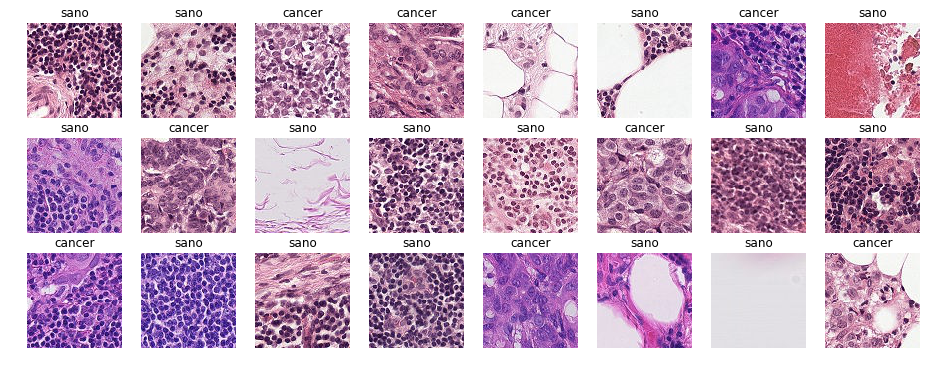

In [4]:
dataset.plot_images(columns=8, rows=3)

## Add transforms

In [5]:
data_transforms = transforms.Compose([
    #transforms.CenterCrop(32),
    transforms.Pad(64, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data_transforms_test = transforms.Compose([
    #transforms.CenterCrop(32),
    transforms.Pad(64, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset.transforms = data_transforms
test_ds.transforms = data_transforms_test

## Split in train/valid

In [6]:
train_ds, valid_ds = dataset.split(val_size=0.1)
valid_ds.limit=512
print("There are", len(train_ds), "images in the train dataset.")
print("There are", len(valid_ds), "images in the validation dataset.")

There are 10000 images in the train dataset.
There are 512 images in the validation dataset.


# Train

In [7]:
dl = DeepLearner("resnet18", train_ds, valid_ds, test_ds, batch_size=512) # batch_size=512

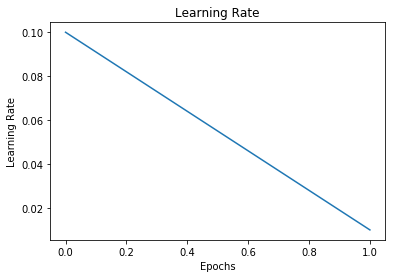

In [8]:
#epochs         = [0,1,2,3] #[0, 15, 30, 35]
#learning_rates = [0, 0.1, 0.005, 0]
epochs         = [0,1]
learning_rates = [0.1, 0.01]
plot_lr(epochs, learning_rates)

Total time: 00:53
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
epoch                                                                   (00:00)
1/1	0:53	0.0100		0.0014	0.0010		0.0014	0.0010                           (00:53)



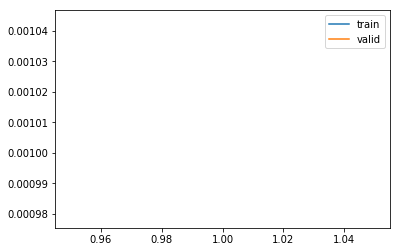

In [9]:
dl.train(epochs, learning_rates)

# Test

In [9]:
dl.load_model()

In [10]:
def test_epoch(dl):
	preds = []
	dl.model.train(False)
	for batch in tqdm(dl.test_batches):
		inputs  = batch[0].to(dl.device)
		labels  = batch[1].to(dl.device)
		if dl.half_prec:
			inputs, labels = inputs.half(), labels.half()
		output = dl.model(inputs)
		pr = output.detach().cpu().numpy()
		for i in pr:
			preds.append(i)
	return preds

In [11]:
#preds = test_epoch(dl)

In [28]:
test_preds = pd.DataFrame({'id': test_ds.images, 'label': preds})

In [29]:
test_preds['id'] = test_preds['id'].apply(lambda x: x.split('.')[0])

In [30]:
test_preds.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.009773
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.270020
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.045135
3,2c35657e312966e9294eac6841726ff3a748febf,0.647461
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.062866


In [31]:
test_preds.to_csv('PCam_sub.csv', index=False)